# Implement Personalized Pagerank

[1] A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html

[2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry, The PageRank citation ranking: Bringing order to the Web. 1999 http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf


In [35]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import pickle
import random

from collections import defaultdict

## Read in files

In [8]:
def read_g_obj(file="adj_matrices/G_hci.pkl"):
    with open(file, "rb") as pfile: 
        G = pickle.load(pfile)
    
    follows_at_least_10 = [person for person, out_degree in G.out_degree() if out_degree >= 10] 
    
    subgraph_hci = nx.subgraph(G, follows_at_least_10)
    
    return subgraph_hci
    

In [9]:
subgraph_hci = read_g_obj(file="adj_matrices/G_hci.pkl")

In [12]:
# this is the full graph!

len(subgraph_hci.edges)

31552

In [13]:
with open("train_test/train.pkl", "rb") as pfile: 
    train = pickle.load(pfile)

In [14]:
with open("train_test/test.pkl", "rb") as pfile: 
    test = pickle.load(pfile)

## Reconstruct Graph

In [16]:
G_train = nx.from_edgelist(train, create_using=nx.DiGraph)

In [18]:
# ok good, there is list 70 of the edges missing!
len(G_train.edges)

22480

In [24]:
# make sure test set leakage

any([train_edge in test for train_edge in list(G_train.edges)])

False

Ok good, none of the test edges are in the train edges

## Do some object oriented stuff

In [69]:
class PageRanker:
    def __init__(self, G, alpha=0.85):
        """
        G (nx.DiGraph):
            the graph object for this network
        alpha (float):
            the walk continues probability
        
        """
        
        self.G = G
        self.alpha = alpha
        self.output = {}
    
    def get_overall_pagerank(self):
        
        # turn into a list so my other classes work
        return [(k, v) for k,v in nx.pagerank(self.G, alpha=self.alpha).items()]
    
    def get_personalized_pagerank(self, node):
        """
        node (str):
            the name of the node
        """
        
        # you always go back to yourself
        return [(k, v) for k,v in nx.pagerank(self.G, alpha=self.alpha, personalization={node : 1}).items()] 
    
    def test(self, personalized=True):
        
        if not personalized:
            self.output = {"overall" : self.get_overall_pagerank()}
        else:
            # compute personalized pagerank for every node
            
            for n in self.G.nodes:
                self.output[n] = self.get_personalized_pagerank(n)
                
        return self.output
        
        
            

In [518]:
class UserRecommendations:
    def __init__(self):
        self.recs = []
        
    def add_entry(self, entry):
        self.recs.append(entry)
        
    def select_top_k(self, k):
        self.recs = sorted(self.recs, key=lambda x: x[1], reverse=True)
        if len(self.recs) > k:
            self.recs = self.recs[0:k]

            
class TestRecommendations:
    def __init__(self, G):
        self.test_recs = defaultdict(UserRecommendations)
        self.G = G
        
    def setup(self, preds, k):
        """
        pred (dict)
            of {user: [(other_user1, pr_score1), (other_user2, pr_score2)], ...}
        
        """
        
        
        for user, rec_list in preds.items():
            for entry in rec_list:
                try:
                    if entry[0] == user:
                        # don't add yourself to the recs
                        continue

                    if (user, entry[0]) in self.G.out_edges(user):
                        # don't add nodes that already exist
                        continue
                    self.test_recs[user].add_entry(entry)
                except Exception as e:
                    print(e, "-----")
                    print((user, entry[0]))
        """        
        for entry in preds:
            user = entry[0]
            self.test_recs[user].add_entry(entry)
        """
            
        for user in self.test_recs.keys():
            self.test_recs[user].select_top_k(k)
            
    def iter_recs(self):
        for user in self.test_recs.keys():
            yield (user, self.test_recs[user].recs)

In [519]:
class Evaluator(ABC):
    def __init__(self):
        self.results_table = None
        self.score = None
        
    def setup(self, trainset, testset):
        pass
    
    def evaluate(self, test_recs: TestRecommendations):
        # for every user and list of recommendations we produce, 
        # evaluate each user (which varies depending on list or itemwise)
        # and then average that over all users!
        
        self.results_table = {}
        scores = []
        for user, recs in test_recs.iter_recs():
            score = self.evaluate_user(user, recs)
            scores.append(score)
            self.results_table[user] = score
        self.score = np.mean(scores)
        
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass
    
class ItemwiseEvaluator(Evaluator):
    def evaluate_user(self, user, user_recs):
        return np.mean([self.evaluate_pred(rec) for rec in user_recs])
    
    @abstractmethod
    def evaluate_pred(self, pred):
        pass
    
class ListwiseEvaluator(Evaluator):
    
    @abstractmethod
    def evaluate_user(self, user, user_recs):
        pass


In [520]:
class NDCGEvaluator(ListwiseEvaluator):
    
    def __init__(self, k):
        super().__init__()
        self.k = k
        self.rated_table = defaultdict(set)
        self.idcg = {}
    
    def setup(self, trainset, testset):
        for user, out_link in testset:
            self.rated_table[user].add(out_link)
                
        idcg = 0
        self.idcg[0] = 0
        for i in range(0, self.k):
            idcg += 1/np.log2(i+2)
            self.idcg[i+1] = idcg
                 
    def evaluate_user(self, user, user_recs):
        """
        user 
            node name
            
        user_recs
            should be a list of (other node, pagerank) tuples
        """
        

        dcg = 0.0
        for i, rec in enumerate(user_recs):
            # print("user:", user, "i", i, "rec:" , rec)
            
            # the first thing in the tuple is the other edge
            if rec[0] in self.rated_table[user]:
                
                #print(f'Rated: {i} Item {pred.iid}')
                dcg += 1/np.log2(i+2)
                
        count_rated_things = len(self.rated_table[user])
        if count_rated_things > self.k:
            count_rated_things = self.k
        
        idcg = self.idcg[count_rated_things]
        
        if idcg == 0:
            return 0
        #print(dcg)
        #print(idcg)
        return dcg/idcg

### Check this with a teeny graph

In [521]:
small_graph = nx.barabasi_albert_graph(20, 3, seed=0).to_directed()


In [522]:
small_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [523]:
len(small_graph.edges())

102

In [524]:
small_test_set = []

for _ in range(len(small_graph.edges())//3):
    edge = random.choice(list(small_graph.edges()))
    
    small_test_set.append(edge)
    small_graph.remove_edges_from([edge])
    

print(len(small_test_set))

34


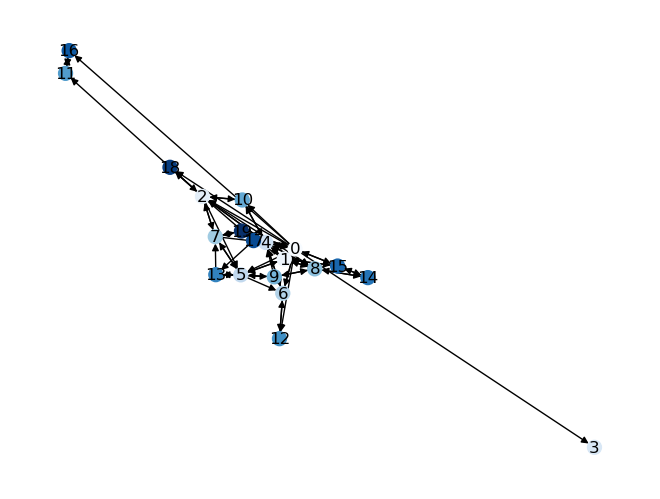

In [525]:
nx.draw(
    small_graph, 
    with_labels=True, 
    node_color=range(len(small_graph.nodes)), 
    node_size=100,
    cmap=plt.cm.Blues
)
plt.show()

In [526]:
pageranker = PageRanker(small_graph)

In [527]:
pageranker.test(personalized=False)

{'overall': [(0, 0.07950827602623053),
  (1, 0.06131824011048638),
  (2, 0.07005539338308005),
  (3, 0.013714784322928698),
  (4, 0.0940904803795687),
  (5, 0.05566310007142701),
  (6, 0.06656116938587466),
  (7, 0.04879371946336269),
  (8, 0.05845539451789359),
  (9, 0.028016062764558022),
  (10, 0.03448790055998306),
  (11, 0.09793751912637931),
  (12, 0.03257400587777202),
  (13, 0.026510159094142283),
  (14, 0.030528157358935465),
  (15, 0.035376227671981945),
  (16, 0.09695439794452439),
  (17, 0.01552635116430916),
  (18, 0.021158253588787316),
  (19, 0.032770407187774825)]}

In [528]:
pageranker = PageRanker(small_graph)
test_recs = pageranker.test(personalized=True)

In [529]:
tr = TestRecommendations(small_graph)
k = 5

In [530]:
tr.setup(test_recs, k=k)

In [531]:
list(tr.iter_recs())[0]

(0,
 [(11, 0.07634795879087448),
  (8, 0.03751586792743116),
  (7, 0.033987710500850206),
  (14, 0.016743255507744186),
  (13, 0.012843922942573681)])

In [532]:
ndcg = NDCGEvaluator(k=k)

In [533]:
ndcg.setup(trainset=None, testset=small_test_set)

In [534]:
ndcg.evaluate(tr)

In [535]:
ndcg.score

0.3218982389716563

I think this is the ideal case for this algorithm!

## Try it on the HCI social network

In [536]:
pageranker_hci = PageRanker(G_train)

In [537]:
hci_test_recs = pageranker_hci.test(personalized=True)

In [538]:
tr_hci = TestRecommendations(G_train)
k = 5

In [539]:
tr_hci.setup(hci_test_recs, k=k)

In [540]:
list(tr_hci.iter_recs())[0]

('cqz',
 [('andresmh', 0.014141595061890956),
  ('cfiesler', 0.011183978518350377),
  ('sigchi', 0.010319217162547642),
  ('bkeegan', 0.00856568847807107),
  ('eglassman', 0.007818924626093826)])

In [542]:
ndcg_hci = NDCGEvaluator(k=k)

In [543]:
ndcg_hci.setup(trainset=None, testset=test)

In [544]:
ndcg_hci.evaluate(tr_hci)

In [545]:
ndcg_hci.score

0.3717419868816553

This is really good, but it is probably just recommending really popular people!

## TODO: Inverse propensity score weighting